In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import implicit
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import precision_at_k, mean_average_precision_at_k
import warnings
warnings.filterwarnings('ignore') 




In [90]:
# Correct file paths for loading CSV files from GitHub
filepath = 'https://raw.githubusercontent.com/fedeamedeo/machine-learning-project/main/Data/'
interactions = pd.read_csv(filepath + 'interactions_train.csv')
items = pd.read_csv('items_enriched_openlibrary.csv')

In [91]:
items_sana= pd.read_csv('items_improved.csv')

In [92]:
items

,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4
...,...,...,...,...,...,...
15286,Le vagabond de Tokyo /,"Fukutani, Takashi, 1952-2000",9782353480111; 235348011X; 9782353480241; 2353...,Le Lézard noir,Mangas,15286
15287,God of high school : le match contre les dieux /,"Park, Yong-Je",9782382880203; 2382880201; 9782382880210; 2382...,Kbooks,NaN,15287
15288,Blue Lock /,"Kaneshiro, Muneyuki",9782811650254; 2811650253; 9782811661274; 2811...,Pika,Compétitions; Football; Entraînement (sports);...,15288
15289,Red eyes sword : akame ga kill ! Zero /,Takahiro,9782368522134; 2368522131; 9782368522141; 2368...,Kurokawa,Bandes dessinées; Mangas,15289


In [93]:
# Set index to align rows by book ID
items = items.set_index('i')
items_sana = items_sana.set_index('i')

# Fill missing values in `items` using values from `items_sana`
items.update(items_sana)

# Reset index if needed
items = items.reset_index()

In [94]:
items

,i,Title,Author,ISBN Valid,Publisher,Subjects
0,0,Classification décimale universelle : édition ...,UDC Consortium (The Hague),9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...
1,1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...
2,2,Histoire de vie et recherche biographique : pe...,Aneta Slowik,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...
3,3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...
4,4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...
...,...,...,...,...,...,...
15286,15286,Le vagabond de Tokyo /,"Fukutani, Takashi, 1952-2000",9782353480111; 235348011X; 9782353480241; 2353...,Le Lézard noir,Mangas
15287,15287,God of high school : le match contre les dieux /,"Park, Yong-Je",9782382880203; 2382880201; 9782382880210; 2382...,Kbooks,Uncategorized
15288,15288,Blue Lock /,"Kaneshiro, Muneyuki",9782811650254; 2811650253; 9782811661274; 2811...,Pika,Compétitions; Football; Entraînement (sports);...
15289,15289,Red eyes sword : akame ga kill ! Zero /,Takahiro,9782368522134; 2368522131; 9782368522141; 2368...,Kurokawa,Bandes dessinées; Mangas


In [100]:
# Load book metadata
items['content'] = items['Title'].fillna('') + ' ' + \
                   items['Author'].fillna('') + ' ' + \
                   items['Subjects'].fillna('') + ' ' + \
                   items['Publisher'].fillna('')

In [101]:
items['content']

0        Classification décimale universelle : édition ...
1        Les interactions dans l'enseignement des langu...
2        Histoire de vie et recherche biographique : pe...
3        Ce livre devrait me permettre de résoudre le c...
4        Les années glorieuses : roman / Lemaitre, Pier...
                               ...                        
15286    Le vagabond de Tokyo / Fukutani, Takashi, 1952...
15287    God of high school : le match contre les dieux...
15288    Blue Lock / Kaneshiro, Muneyuki Compétitions; ...
15289    Red eyes sword : akame ga kill ! Zero / Takahi...
15290    Directives de projet applicables à l'étude et ...
Name: content, Length: 15291, dtype: object

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(items['content'])


In [103]:
from scipy.sparse import csr_matrix

# Merge interactions and items to match on 'i'
merged = interactions.merge(items[['i']], on='i')

# Create a user profile: mean of TF-IDF vectors of books they've interacted with
user_profiles = {}
for user_id, group in merged.groupby('u'):
    indices = group['i'].values
    profile = tfidf_matrix[indices].mean(axis=0).A1 
    user_profiles[user_id] = profile


In [104]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

recommendations = []

for user_id, profile in user_profiles.items():
    # Reshape profile to ensure compatibility with tfidf_matrix
    sims = cosine_similarity(profile.reshape(1, -1), tfidf_matrix).flatten()
    top_indices = np.argsort(-sims)[:10]  # top 10
    book_ids = items.iloc[top_indices]['i'].tolist()
    recommendations.append((user_id, book_ids))


In [105]:
import csv

with open("content_recommendations.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["user_id", "recommendation"])
    for user_id, book_ids in recommendations:
        writer.writerow([user_id, " ".join(map(str, book_ids))])


### stop here and use content reccom

In [106]:
def precision_recall_at_k(recommendations, test_data, k=10):
    # Build ground truth per user
    ground_truth = test_data.groupby('u')['i'].apply(set).to_dict()

    precisions = []
    recalls = []

    for user_id, predicted_items in recommendations:
        predicted_top_k = predicted_items[:k]
        true_items = ground_truth.get(user_id, set())

        if not true_items:
            continue  # skip users with no test items

        hits = len(set(predicted_top_k) & true_items)

        precision = hits / k
        recall = hits / len(true_items)

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)


In [115]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
from collections import defaultdict

# Load data

# Build content
items['content'] = (
    items['Title'].fillna('') + ' ' +
    items['Author'].fillna('') + ' ' +
    items['Subjects'].fillna('') + ' ' +
    items['Publisher'].fillna('')
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(items['content'])
item_ids = items['i'].tolist()

# Build a fast lookup
item_index_lookup = {item_id: idx for idx, item_id in enumerate(item_ids)}

# Cross-validation setup
n_splits = 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = []

user_groups = interactions.groupby('u')

for fold_id in range(5):
    train_parts = []
    test_parts = []

    for user_id, user_data in user_groups:
        if len(user_data) < n_splits:
            continue  # Skip users with too few interactions

        indices = np.arange(len(user_data))
        split = list(kf.split(indices))[fold_id]
        train_idx, test_idx = split

        train_parts.append(user_data.iloc[train_idx])
        test_parts.append(user_data.iloc[test_idx])


    train_fold = pd.concat(train_parts)
    test_fold = pd.concat(test_parts)
    folds.append((train_fold.reset_index(drop=True), test_fold.reset_index(drop=True)))

# Evaluation function
def precision_recall_at_k(recommendations, test_data, k=10):
    truth = test_data.groupby('u')['i'].apply(set).to_dict()
    p_total, r_total, n_users = 0, 0, 0

    for user_id, recs in recommendations.items():
        if user_id not in truth:
            continue
        actual = truth[user_id]
        pred = recs[:k]
        hits = len(set(pred) & actual)
        p_total += hits / k
        r_total += hits / len(actual)
        n_users += 1

    return p_total / n_users, r_total / n_users

# Main loop
all_precisions, all_recalls = [], []

for fold_idx, (train_data, test_data) in enumerate(folds):
    user_profiles = {}
    for user_id, group in train_data.groupby('u'):
        book_ids = group['i'].tolist()
        book_indices = [item_index_lookup[b] for b in book_ids if b in item_index_lookup]
        if book_indices:
            profile = tfidf_matrix[book_indices].mean(axis=0)
            user_profiles[user_id] = profile

    # Recommendations
    recommendations = defaultdict(list)
    for user_id, profile in user_profiles.items():
        sims = cosine_similarity(profile, tfidf_matrix).flatten()
        seen = set(train_data[train_data['u'] == user_id]['i'])
        ranked = np.argsort(-sims)
        recs = [item_ids[i] for i in ranked if item_ids[i] not in seen][:10]
        recommendations[user_id] = recs

    p, r = precision_recall_at_k(recommendations, test_data, k=10)
    all_precisions.append(p)
    all_recalls.append(r)
    print(f"Fold {fold_idx+1} → Precision@10: {p:.4f}, Recall@10: {r:.4f}")

# Final mean results
print(f"\n📈 Mean Precision@10: {np.mean(all_precisions):.4f}")
print(f"📈 Mean Recall@10: {np.mean(all_recalls):.4f}")


TypeError: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

### finish embeddings

Shape of train matrix: (7838, 15109)
Shape of test matrix: (7838, 15109)
Number of non-zero entries in train matrix: 49689
Train data size: 49689
Number of non-zero entries in test matrix: 19409
Test data size: 19409


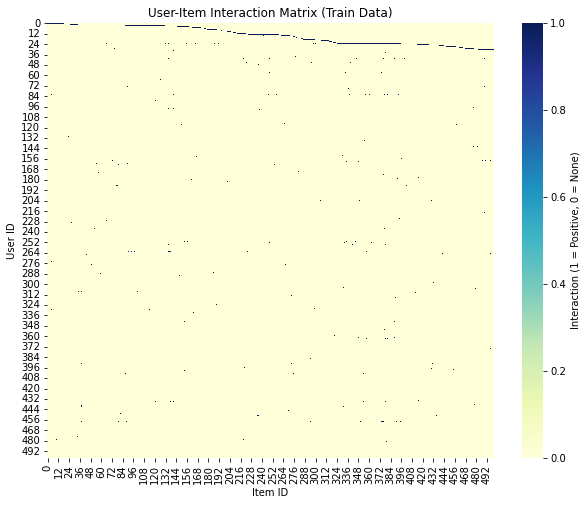

Item-Item Similarity Matrix:
[[1.         0.40824829 0.33333333 ... 0.         0.         0.        ]
 [0.40824829 1.         0.40824829 ... 0.         0.         0.        ]
 [0.33333333 0.40824829 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]
(15109, 15109)


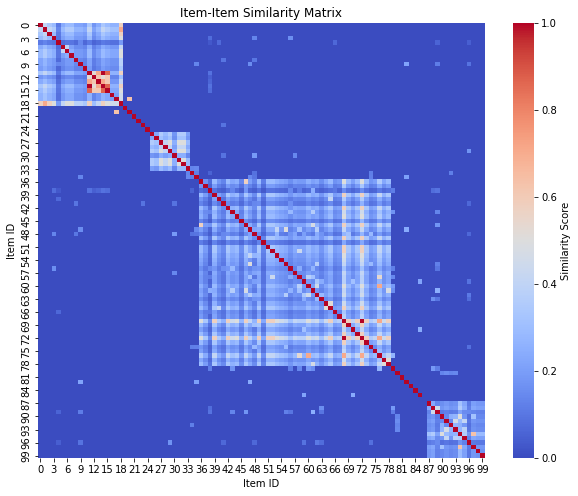

Predicted Interaction Matrix:
[[0.46097255 0.85435984 0.71867834 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(7838, 15109)


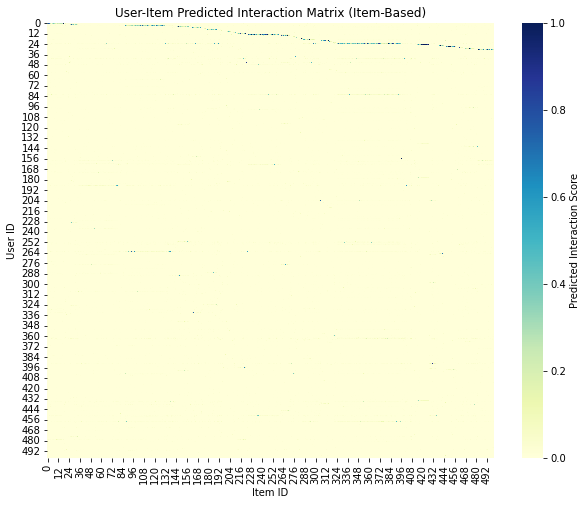

User-User Similarity Matrix:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Shape of User Similarity Matrix: (7838, 7838)


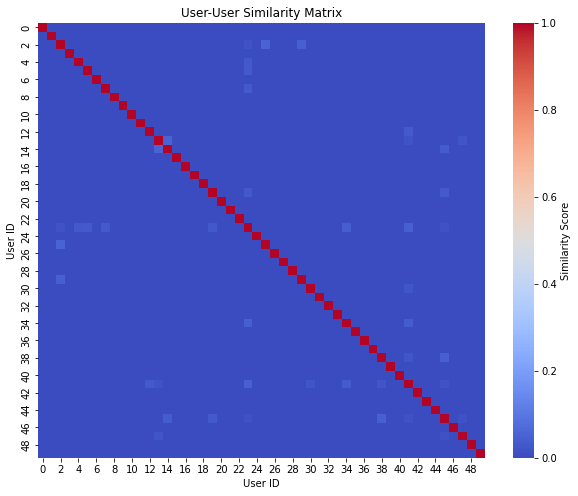

Predicted Interaction Matrix (User-Based):
[[0.13171649 0.13259591 0.14274867 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(7838, 15109)


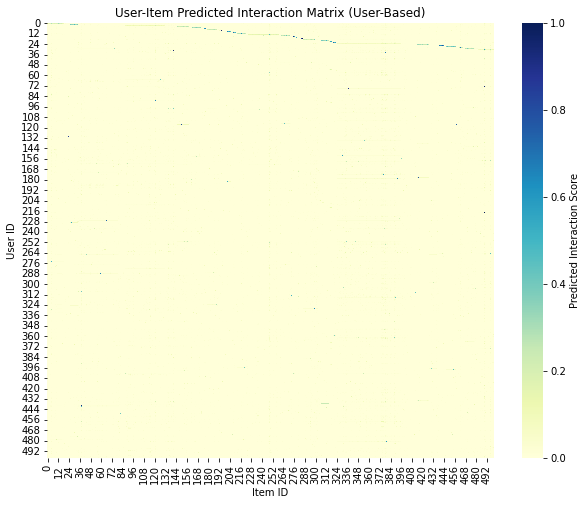

User-based CF Precision@K: 0.056455728502171655
User-based CF Recall@K: 0.2899013913583887
Item-based CF Precision@K: 0.05567746874202883
Item-based CF Recall@K: 0.2640441131423877


In [60]:
# let's first sort the interactions by user and time stamp
#interactions['datetime'] = pd.to_datetime(interactions['t'], unit='s')
interactions = interactions.sort_values(["u", "t"])
interactions.head(10)
n_users = interactions["u"].nunique()
n_items = interactions["i"].nunique()
#Function to define ground truth matrix
def create_data_matrix(data, n_users, n_items):
    """
    This function returns a numpy matrix with shape (n_users, n_items).
    Each entry is a binary value indicating positive interaction.
    """
    data_matrix = np.zeros((n_users, n_items))
    for row in data.itertuples():
        data_matrix[row.u, row.i] = 1  # Binary representation of interaction
    return data_matrix



# Map user and item IDs to zero-based indices
user_id_mapping = {user_id: idx for idx, user_id in enumerate(interactions["u"].unique())}
item_id_mapping = {item_id: idx for idx, item_id in enumerate(interactions["i"].unique())}
item_id_mapping_rev = {v: k for k, v in item_id_mapping.items()}
interactions["u"] = interactions["u"].map(user_id_mapping)
interactions["i"] = interactions["i"].map(item_id_mapping)

# Split the data into training and testing sets
interactions["pct_rank"] = interactions.groupby("u")["t"].rank(pct=True, method='dense')
train_data = interactions[interactions["pct_rank"] < 0.8]
test_data = interactions[interactions["pct_rank"] >= 0.8]

# Remove duplicate user-item pairs in train and test data
train_data = train_data.drop_duplicates(subset=["u", "i"])
test_data = test_data.drop_duplicates(subset=["u", "i"])

# Get the number of unique users and items
n_users = interactions["u"].nunique()
n_items = interactions["i"].nunique()

# Create the training and testing matrices
train_data_matrix = create_data_matrix(train_data, n_users, n_items)
test_data_matrix = create_data_matrix(test_data, n_users, n_items)

# Print results
print(f"Shape of train matrix: {train_data_matrix.shape}")
print(f"Shape of test matrix: {test_data_matrix.shape}")
print(f"Number of non-zero entries in train matrix: {np.count_nonzero(train_data_matrix)}")
print(f"Train data size: {train_data.shape[0]}")
print(f"Number of non-zero entries in test matrix: {np.count_nonzero(test_data_matrix)}")
print(f"Test data size: {test_data.shape[0]}")
import numpy as np

# Define a function to create the data matrix
def create_data_matrix(data, n_users, n_items):
    """
    This function returns a numpy matrix with shape (n_users, n_items).
    Each entry is a binary value indicating positive interaction.
    """
    data_matrix = np.zeros((n_users, n_items))
    data_matrix[data["u"].values, data["i"].values] = 1
    return data_matrix
# Function to plot a heatmap for a subset of the user-item matrix
def plot_interaction_heatmap(data_matrix, title, num_users=500, num_items=500):
    """
    Plots a heatmap of a subset of the user-item interaction matrix.
    Parameters:
        data_matrix: The matrix to visualize.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    # Extract a subset of the matrix for visualization purposes
    matrix_subset = data_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Interaction (1 = Positive, 0 = None)'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the training and testing matrices
plot_interaction_heatmap(train_data_matrix, 'User-Item Interaction Matrix (Train Data)')
# Compute the item-item similarity matrix
item_similarity = cosine_similarity(train_data_matrix.T)
print("Item-Item Similarity Matrix:")
print(item_similarity)
print(item_similarity.shape)
# Function to visualize the item similarity matrix
def plot_item_similarity_heatmap(similarity_matrix, title, num_items=100):
    """
    Plots a heatmap of a subset of the item similarity matrix.
    Parameters:
        similarity_matrix: The item-item similarity matrix.
        title: The title of the plot.
        num_items: The number of items to display (both rows and columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = similarity_matrix[:num_items, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="coolwarm", cbar=True, cbar_kws={'label': 'Similarity Score'})
    plt.xlabel('Item ID')
    plt.ylabel('Item ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the item similarity matrix
plot_item_similarity_heatmap(item_similarity, 'Item-Item Similarity Matrix')
# Define the function to predict interactions based on item similarity
def item_based_predict(interactions, similarity, epsilon=1e-9):
    """
    Predicts user-item interactions based on item-item similarity.
    Parameters:
        interactions (numpy array): The user-item interaction matrix.
        similarity (numpy array): The item-item similarity matrix.
        epsilon (float): Small constant added to the denominator to avoid division by zero.
    Returns:
        numpy array: The predicted interaction scores for each user-item pair.
    """
    # np.dot does the matrix multiplication. Here we are calculating the
    # weighted sum of interactions based on item similarity
    pred = similarity.dot(interactions.T) / (similarity.sum(axis=1)[:, np.newaxis] + epsilon)
    return pred.T  # Transpose to get users as rows and items as columns

# Calculate the item-based predictions for positive interactions
item_prediction = item_based_predict(train_data_matrix, item_similarity)
print("Predicted Interaction Matrix:")
print(item_prediction)
print(item_prediction.shape)
# Function to visualize the predicted interaction matrix for a subset of users and items
def plot_interaction_prediction_heatmap(prediction_matrix, title, num_users=500, num_items=500):
    """
    Plots a heatmap of a subset of the user-item predicted interaction matrix.
    Parameters:
        prediction_matrix: The predicted interaction matrix.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = prediction_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Predicted Interaction Score'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the predicted interaction matrix
plot_interaction_prediction_heatmap(item_prediction, 'User-Item Predicted Interaction Matrix (Item-Based)')
# Compute the user-user similarity matrix
user_similarity = cosine_similarity(train_data_matrix)
print("User-User Similarity Matrix:")
print(user_similarity)

# Check the shape as a sanity check
print("Shape of User Similarity Matrix:", user_similarity.shape)
# Function to plot the user similarity matrix
def plot_user_similarity_heatmap(similarity_matrix, title, num_users=50):
    """
    Plots a heatmap of a subset of the user similarity matrix.
    Parameters:
        similarity_matrix: The user-user similarity matrix.
        title: The title of the plot.
        num_users: The number of users to display (both rows and columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = similarity_matrix[:num_users, :num_users]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="coolwarm", cbar=True, cbar_kws={'label': 'Similarity Score'})
    plt.xlabel('User ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the user similarity matrix
plot_user_similarity_heatmap(user_similarity, 'User-User Similarity Matrix')
# Define the function to predict interactions based on user similarity
def user_based_predict(interactions, similarity, epsilon=1e-9):
    """
    Predicts user-item interactions based on user-user similarity.
    Parameters:
        interactions (numpy array): The user-item interaction matrix.
        similarity (numpy array): The user-user similarity matrix.
        epsilon (float): Small constant added to the denominator to avoid division by zero.
    Returns:
        numpy array: The predicted interaction scores for each user-item pair.
    """
    # Calculate the weighted sum of interactions based on user similarity
    pred = similarity.dot(interactions) / (np.abs(similarity).sum(axis=1)[:, np.newaxis] + epsilon)
    return pred

# Calculate the user-based predictions for positive interactions
user_prediction = user_based_predict(train_data_matrix, user_similarity)
print("Predicted Interaction Matrix (User-Based):")
print(user_prediction)
print(user_prediction.shape)
# Function to visualize the predicted interaction matrix for a subset of users and items
def plot_interaction_prediction_heatmap(prediction_matrix, title, num_users=500, num_items=500):
    """
    Plots a heatmap of a subset of the user-item predicted interaction matrix.
    Parameters:
        prediction_matrix: The predicted interaction matrix.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = prediction_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Predicted Interaction Score'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the predicted interaction matrix
plot_interaction_prediction_heatmap(user_prediction, 'User-Item Predicted Interaction Matrix (User-Based)')
#Defining the function for precision and recall @K
def precision_recall_at_k(prediction, ground_truth, k=10):
    """
    Calculates Precision@K and Recall@K for top-K recommendations.
    Parameters:
        prediction (numpy array): The predicted interaction matrix with scores.
        ground_truth (numpy array): The ground truth interaction matrix (binary).
        k (int): Number of top recommendations to consider.
    Returns:
        precision_at_k (float): The average precision@K over all users.
        recall_at_k (float): The average recall@K over all users.
    """
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k = 0, 0

    for user in range(num_users):
        # Get the indices of the top-K items for the user based on predicted scores
        top_k_items = np.argsort(prediction[user, :])[-k:]

        # Calculate the number of relevant items in the top-K items for the user
        relevant_items_in_top_k = np.isin(top_k_items, np.where(ground_truth[user, :] == 1)[0]).sum()

        # Calculate the total number of relevant items for the user
        total_relevant_items = ground_truth[user, :].sum()

        # Precision@K and Recall@K for this user
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant_items if total_relevant_items > 0 else 0

    # Average Precision@K and Recall@K over all users
    precision_at_k /= num_users
    recall_at_k /= num_users

    return precision_at_k, recall_at_k
#Precision and recall @k for user- and item-based CF
precision_user_k, recall_user_k = precision_recall_at_k(user_prediction, test_data_matrix, k=10)
precision_item_k, recall_item_k = precision_recall_at_k(item_prediction, test_data_matrix, k=10)

print('User-based CF Precision@K:', precision_user_k)
print('User-based CF Recall@K:', recall_user_k)
print('Item-based CF Precision@K:', precision_item_k)
print('Item-based CF Recall@K:', recall_item_k)
# Create reverse mappings from internal to original IDs
reverse_user_mapping = {v: k for k, v in user_id_mapping.items()}
reverse_item_mapping = {v: k for k, v in item_id_mapping.items()}



In [61]:
# Define top-k recommendations
top_k = 10
submission_rows = []

for user_id in range(user_prediction.shape[0]):
    # Get top-k item indices (internal)
    top_items = np.argsort(user_prediction[user_id])[-top_k:][::-1]

    # Convert internal user and item IDs back to original
    original_user_id = reverse_user_mapping[user_id]
    original_item_ids = [reverse_item_mapping[i] for i in top_items]

    # Format the recommendations as a space-separated string
    recommendations_str = ' '.join(map(str, original_item_ids))

    submission_rows.append([original_user_id, recommendations_str])

# Create a DataFrame for submission
submission_df = pd.DataFrame(submission_rows, columns=['user_id', 'recommendation'])

In [65]:
# Step 1: Align item indices
cf_item_ids = set(range(user_prediction.shape[1]))
cb_item_ids = set(items['i'].map(item_id_mapping))

common_item_ids = list(cf_item_ids & cb_item_ids)
common_item_ids.sort()

# Step 2: Create index maps
cf_to_common_idx = [i for i in common_item_ids]
cb_to_common_idx = [item_id_mapping_rev[i] for i in common_item_ids]  # Reverse map from item_id

alpha = 0.6
# Step 3: Combine CF and CB scores
hybrid_recommendations = []

for user_id in range(user_prediction.shape[0]):
    cf_scores = user_prediction[user_id][cf_to_common_idx]

    if user_id in user_profiles:
        cb_profile = user_profiles[user_id].reshape(1, -1)
        cb_scores_full = cosine_similarity(cb_profile, tfidf_matrix).flatten()
        cb_scores = cb_scores_full[cb_to_common_idx]
    else:
        cb_scores = np.zeros(len(common_item_ids))

    # Hybrid score
    hybrid_scores = alpha * cb_scores  + (1 - alpha) * cf_scores
    top_indices = np.argsort(hybrid_scores)[-10:][::-1]
    top_items = [common_item_ids[i] for i in top_indices]

    original_user_id = reverse_user_mapping[user_id]
    original_item_ids = [reverse_item_mapping[i] for i in top_items]
    hybrid_recommendations.append([original_user_id, " ".join(map(str, original_item_ids))])


In [66]:
# Create DataFrame
submission_df = pd.DataFrame(hybrid_recommendations, columns=["user_id", "recommendation"])

# Save to CSV
submission_df.to_csv("hybrid_submission.csv", index=False)

print("✅ hybrid_submission.csv created successfully.")

✅ hybrid_submission.csv created successfully.
